# Survival Analysis

This example notebook shows how to use the functionalities for survival analysis. The examples in this notebook were contributed by Iwan Paolucci ([\@ipa](https://github.com/ipa) on GitHub).

*This example notebook shall not be an introduction into survival analysis but rather a showcase for the funcionality in bambi.*

In [1]:
import bambi as bmb
import arviz as az
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import seaborn as sns

Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable efl


## Prepare data

For this example we will use the veterans data set included in the R survival package.

https://www.rdocumentation.org/packages/survival/versions/3.3-1/topics/veteran

In [2]:
data = pd.read_csv(os.path.join("data", "veteran.csv"))

Let's first add the labels to the treatment and celltype column

In [3]:
lookup_table = {
    'trt': {1: 'Standard', 2: 'Test'},
    'celltype': {1: 'Squamous', 2: 'Smallcell', 3: 'Adeno', 4: 'Large'},
}

In [4]:
data['trt_str'] = [lookup_table['trt'][x] for x in data['trt']]
data['celltype_str'] = [lookup_table['celltype'][x] for x in data['celltype']]

In [5]:
data

,time,status,karno,diagtime,age,prior,trt,celltype,trt_str,celltype_str
0,72,1,60,7,69,0,1,1,Standard,Squamous
1,411,1,70,5,64,10,1,1,Standard,Squamous
2,228,1,60,3,38,0,1,1,Standard,Squamous
3,126,1,60,9,63,10,1,1,Standard,Squamous
4,118,1,70,11,65,10,1,1,Standard,Squamous
...,...,...,...,...,...,...,...,...,...,...
132,133,1,75,1,65,0,2,4,Test,Large
133,111,1,60,5,64,0,2,4,Test,Large
134,231,1,70,18,67,10,2,4,Test,Large
135,378,1,80,4,65,0,2,4,Test,Large


## Survival analysis using the Exponential distribution

In this chapter we will use a parametric survival model using the Exponential distribution. Thus, we assume that the survival times follow an exponential distribution. Therefore, we should first have a look at this distribution. 

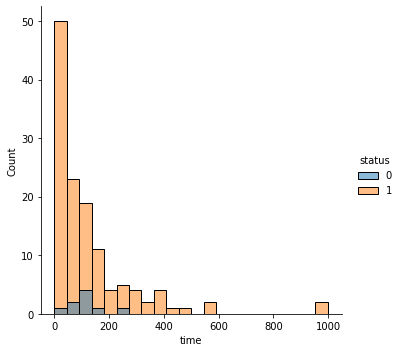

In [6]:
sns.displot(data=data, x='time', hue='status', kind='hist');

Based on the histogram the assumption that the survival times follow an exponential distribution seems to hold.

### Intercept only model

Let's first fit a model with the intercept only to estimate the average survival in the study cohort.

In [7]:
model = bmb.Model(
    "censored(time,status) ~ 1 ",
    data,
    family="exponential"
)

idata = model.fit(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.


In [9]:
summary = az.summary(idata)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.864,0.087,4.691,5.016,0.003,0.002,930.0,1288.0,1.0


The estimates $\lambda$ have to be transformed using $1/exp(\lambda)$ to convert them into a failure rate. We extract the estimates and the uncertainty from the summary table and plot the survival function.
Additionally, we also extract the median survival time.

In [10]:
def median_survival(surv_prob, t):
    median_survival_idx = np.where(surv_prob <= 0.5)[0][0]
    return t[median_survival_idx]

To plot the survival function we use the `sf()` function of the exponential distribution. The survival function is defined as 1 - cumulative distribution function (CDF). In survival analysis the CDF would represent the cumulative incidence function of a failure. 

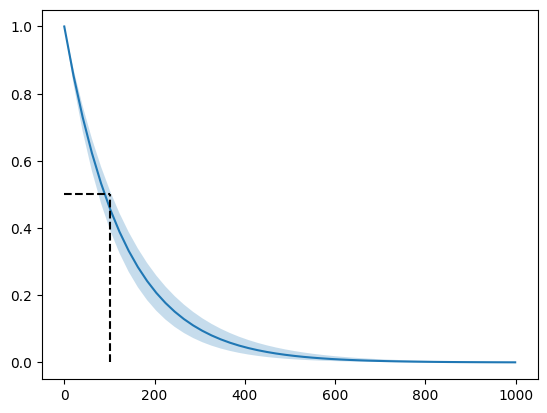

In [11]:
lam = 1/np.exp(summary["mean"]["Intercept"])
lam_lower = 1/np.exp(summary["hdi_3%"]["Intercept"])
lam_upper = 1/np.exp(summary["hdi_97%"]["Intercept"])

t = np.linspace(0, max(data["time"]))
S0 = sp.stats.expon.sf

plt.plot(t, S0(lam * t));
plt.fill_between(t, S0(lam_lower * t), S0(lam_upper * t), alpha=0.25);

med_surv = median_survival(S0(lam * t), t)
plt.hlines(y=0.5, xmin=0, xmax=med_surv, linestyles='dashed', color='black');
plt.vlines(x=med_surv, ymin=0, ymax=0.5, linestyles='dashed', color='black');


In [12]:
print("Median survival at {:.1f} days, CI [{:.1f}, {:.1f}]".format(median_survival(S0(lam * t), t), median_survival(S0(lam_lower * t), t), median_survival(S0(lam_upper * t), t)))

Median survival at 101.9 days, CI [81.6, 122.3]


### Treatment and celltype model

Next let's build a model with the treatment and the celltype. 

Here we use the B() and T() transformation from the formluae package. B() converts the variable into a bool where 'Test' is converted to True. T() converts the variable into a categorical variable with 'Squamous' being the reference value.

In [14]:
model = bmb.Model(
    "censored(time,status) ~ 1 + B(trt_str, success='Test') + T(celltype_str, ref='Squamous')",
    data,
    family="exponential"
)

idata = model.fit(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, B(trt_str, success = Test), T(celltype_str, ref = Squamous)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.


In [15]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,5.566,0.227,5.155,5.992,0.007,0.005,988.0,1241.0,1.0
"B(trt_str, success = Test)",-0.171,0.182,-0.509,0.177,0.005,0.003,1582.0,1686.0,1.0
"T(celltype_str, ref = Squamous)[Adeno]",-1.237,0.267,-1.740,-0.751,0.007,0.005,1365.0,1439.0,1.0
"T(celltype_str, ref = Squamous)[Large]",-0.326,0.275,-0.797,0.237,0.008,0.006,1173.0,1567.0,1.0
"T(celltype_str, ref = Squamous)[Smallcell]",-1.168,0.250,-1.621,-0.693,0.008,0.005,1077.0,1179.0,1.0


#### Interpretation

Based on these results we can conclude that:
* The treatment does not have a significant effect on the outcome since 0 is included in the HDI.
* The celltypes 'Adeno' and 'Smallcell' have significant worse survival (higher rate of death) compared to celltypes 'Squamous' and 'Large'.
* Celltype 'Large' has worse survival than celltype 'Squamous' but this is not significant since 0 (reference rate for 'Squamous') is included in the HDI
* The celltypes 'Adeno' and 'Smallcell' can be considered equivalent in terms of survival

Next we will plot the differenct survival functions for the different celltypes and treatments. Therefore, we create a new dataset to do these predictions.

In [16]:
new_data = pd.DataFrame({
    'trt_str': np.tile(["Standard", "Test"], 4, ),
    'celltype_str': np.repeat(['Squamous', 'Smallcell', 'Adeno', 'Large'], 2),
})
new_data

,trt_str,celltype_str
0,Standard,Squamous
1,Test,Squamous
2,Standard,Smallcell
3,Test,Smallcell
4,Standard,Adeno
5,Test,Adeno
6,Standard,Large
7,Test,Large


In [17]:
model.predict(idata, data=new_data, kind='mean')

Now we add the predictions to the dataset for plotting. Again, we have to convert the estimates to the rates using $1/exp(\lambda)$. We also extract the 95% Credible Interval (int this case the equally tailed interval) to plot the uncertainty. 

In [19]:
samples = idata.posterior["censored(time, status)_mean"].stack(samples=("chain", "draw")).values
preds = np.quantile(samples, q=[0.025, 0.5, 0.975], axis=1)
preds = 1/np.exp(preds)

new_data['lam'] = preds[1, :]
new_data['lam_lower'] = preds[0, :]
new_data['lam_upper'] = preds[2, :]

First we plot the different celltypes for the 'Test' treatment.

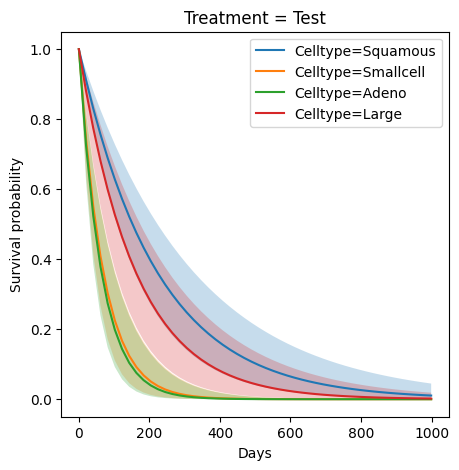

In [20]:
t = np.linspace(0, max(data["time"]))
S0 = sp.stats.expon.sf

plt.figure(figsize=(5, 5))

new_data_test = new_data[new_data['trt_str'] == 'Test']

for i in range(new_data_test.shape[0]):
    celltype = new_data_test.iloc[i]['celltype_str']
    lam = new_data_test.iloc[i]['lam']
    lam_lower = new_data_test.iloc[i]['lam_lower']
    lam_upper = new_data_test.iloc[i]['lam_upper']
    
    plt.plot(t, S0(lam * t), label = "Celltype={}".format(celltype));
    plt.fill_between(t, S0(lam_lower * t), S0(lam_upper * t), alpha=0.25);
    
plt.legend(loc=1);
plt.xlabel("Days")
plt.ylabel("Survival probability")
plt.title("Treatment = Test");

Next we plot the to different treatments for the celltype 'Squamous'.

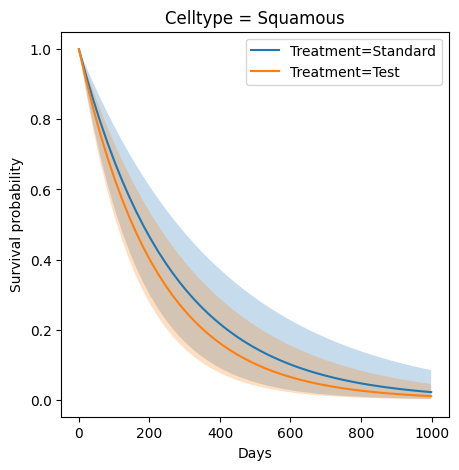

In [21]:
t = np.linspace(0, max(data["time"]))
S0 = sp.stats.expon.sf

plt.figure(figsize=(5, 5))

new_data_test = new_data[new_data['celltype_str'] == 'Squamous']

for i in range(new_data_test.shape[0]):
    trt = new_data_test.iloc[i]['trt_str']
    lam = new_data_test.iloc[i]['lam']
    lam_lower = new_data_test.iloc[i]['lam_lower']
    lam_upper = new_data_test.iloc[i]['lam_upper']
    
    plt.plot(t, S0(lam * t), label = "Treatment={}".format(trt));
    plt.fill_between(t, S0(lam_lower * t), S0(lam_upper * t), alpha=0.25);
    
plt.legend(loc=1);
plt.xlabel("Days")
plt.ylabel("Survival probability")
plt.title("Celltype = Squamous");

### Interaction model

In a real-world example we would do further analyses and also look at interactions. Here we just do a quick example on modelling the interaction between the treatment and the celltype. 



In [22]:
model = bmb.Model(
    "censored(time,status) ~ 1 + B(trt_str, success='Test') * T(celltype_str, ref='Squamous')",
    data,
    family="exponential"
)

idata = model.fit(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, B(trt_str, success = Test), T(celltype_str, ref = Squamous), B(trt_str, success = Test):T(celltype_str, ref = Squamous)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.


In [23]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.963,0.291,4.419,5.503,0.013,0.010,469.0,737.0,1.01
"B(trt_str, success = Test)",0.728,0.377,0.043,1.459,0.018,0.013,457.0,757.0,1.00
"T(celltype_str, ref = Squamous)[Adeno]",-0.615,0.468,-1.451,0.292,0.018,0.013,701.0,1166.0,1.00
"T(celltype_str, ref = Squamous)[Large]",0.414,0.390,-0.270,1.196,0.016,0.012,579.0,893.0,1.00
"T(celltype_str, ref = Squamous)[Smallcell]",-0.421,0.345,-1.050,0.201,0.015,0.011,542.0,697.0,1.00
"B(trt_str, success = Test):T(celltype_str, ref = Squamous)[Adeno]",-0.907,0.585,-1.960,0.253,0.024,0.017,608.0,1030.0,1.00
"B(trt_str, success = Test):T(celltype_str, ref = Squamous)[Large]",-1.188,0.544,-2.175,-0.148,0.023,0.016,583.0,926.0,1.00
"B(trt_str, success = Test):T(celltype_str, ref = Squamous)[Smallcell]",-1.321,0.489,-2.193,-0.356,0.022,0.016,495.0,879.0,1.01


This output becomes already more challenging to interpret properly, especially without domain knowledge. So let's just go ahead and generate plots to visualize the differences.

In [24]:
new_data = pd.DataFrame({
    'trt_str': np.tile(["Standard", "Test"], 4, ),
    'celltype_str': np.repeat(['Squamous', 'Smallcell', 'Adeno', 'Large'], 2),
})

In [25]:
model.predict(idata, data=new_data, kind='mean')

In [26]:
samples = idata.posterior["Surv(time, status)_mean"].stack(samples=("chain", "draw")).values
preds = np.quantile(samples, q=[0.025, 0.5, 0.975], axis=1)
preds = 1/np.exp(preds)

new_data['lam'] = preds[1, :]
new_data['lam_lower'] = preds[0, :]
new_data['lam_upper'] = preds[2, :]

KeyError: 'Surv(time, status)_mean'

In [ ]:
t = np.linspace(0, max(data["time"]))
S0 = sp.stats.expon.sf

plt.figure(figsize=(5, 5))

new_data_test = new_data[new_data['celltype_str'] == 'Squamous']

for i in range(new_data_test.shape[0]):
    trt = new_data_test.iloc[i]['trt_str']
    lam = new_data_test.iloc[i]['lam']
    lam_lower = new_data_test.iloc[i]['lam_lower']
    lam_upper = new_data_test.iloc[i]['lam_upper']
    
    plt.plot(t, S0(lam * t), label = "Treatment={}".format(trt));
    plt.fill_between(t, S0(lam_lower * t), S0(lam_upper * t), alpha=0.25);
    
plt.legend(loc=1);
plt.xlabel("Days")
plt.ylabel("Survival probability")
plt.title("Celltype = Squamous");

Now, compared to the previous example we can see a larger difference between the treatments, which we can consider significant since the survival curves lie outside the credible intervals. 